In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.ops import unary_union

import matplotlib.pyplot as plt
import seaborn as sns

from libpysal.weights import Kernel
from esda.moran import Moran

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler

In [2]:
# set seaborn theme
sns.set_theme(style='darkgrid')

In [3]:
loc_gdf = gpd.read_file('data/AQMS_loc.shp')

# Initialise

In [ ]:
# Read in all the data

AQMS_df = pd.read_csv('data/hourly.csv')
Rd_gdf = gpd.read_file('data/london_Road.shp')
Gsp_gdf = gpd.read_file('data/LD_GreenSpace.shp')
cond = pd.read_csv('data/cond_hourly.csv')

In [ ]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf = loc_gdf.set_index('siteid')
loc_gdf['buffer_1km'] = loc_gdf['geometry'].buffer(1000)

In [ ]:
Rd_gdf.head()

In [ ]:
for c in Rd_gdf['class'].unique():
    print('Number of ' + c + ': ', Rd_gdf[Rd_gdf['class'] == c].shape[0])

In [ ]:
# Get all green spaces
Gsp = Gsp_gdf['geometry'].unary_union

# Get all types of roads
Rd = {}
for c in Rd_gdf['class'].unique():
    Rd[c] = Rd_gdf[Rd_gdf['class'] == c].loc[:, 'geometry'].unary_union
Rd

In [ ]:
Rd['other'] = unary_union([Rd['Not Classified'], Rd['Unknown']])
Rd.pop('Not Classified')
Rd.pop('Unknown')
Rd

In [ ]:
del Gsp_gdf, Rd_gdf

In [ ]:
loc_gdf['Gsp'] = loc_gdf['buffer_1km'].intersection(Gsp)
for key in Rd.keys():
    loc_gdf[key] = loc_gdf['buffer_1km'].intersection(Rd[key])

loc_gdf.head()

In [ ]:
del Rd

In [ ]:
# Rename columns
loc_gdf.rename(columns={'Unclassified': 'UnC_Rd', 
                        'A Road': 'A_Rd',
                        'B Road': 'B_Rd',
                        'Classified Unnumbered': 'CUn_Rd',
                        'Motorway': 'Mo_Rd',
                        'other': 'O_Rd'}, inplace=True)

Rd_type = loc_gdf.columns[-6:]
Rd_type

In [ ]:
# Get all near-road green spaces
for col in Rd_type:
    loc_gdf['n'+col+'_Gsp'] = loc_gdf['Gsp'].intersection(loc_gdf[col].buffer(50))

loc_gdf.head()

In [ ]:
# london boundary read in
london = gpd.read_file('data/london_boundary.shp')

In [ ]:
# visualise all the sites on the map
fig,ax = plt.subplots(1, figsize=(15,13))

london.plot(color='lightgrey', ax=ax)
loc_gdf['buffer_1km'].plot(color='silver', ax=ax)
loc_gdf['geometry'].plot(markersize=10, marker='^', color='blue', 
                         label='Air quality monitoring site', ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to each other.

In [ ]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis'] = pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis = []
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index, 'min_dis'] = min(dis)

In [ ]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

In [ ]:
# check their readings' descriptive statistics
AQMS_df[AQMS_df['Site'].isin(['BL0', 'CD9', 'GR4', 'GB0'])].groupby('Site').describe()

In [ ]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='BL0'].Value.values,
                AQMS_df[AQMS_df['Site']=='CD9'].Value.values)

In [ ]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='GR4'].Value.values,
                AQMS_df[AQMS_df['Site']=='GB0'].Value.values)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [ ]:
# revmove them from the list
#loc_gdf.drop(['BL0','GR4'], inplace=True)

In [ ]:
# get areas and edge lengths of green spaces 
loc_gdf['Gsp_area'] = loc_gdf['Gsp'].area
loc_gdf['Gsp_edge'] = loc_gdf['Gsp'].length

In [ ]:
# get road lengths of each type and nRd gsp area percentages
for col in Rd_type:
    loc_gdf[col+'_len'] = loc_gdf[col].length
    loc_gdf['pct_n'+col+'_Gsp'] = loc_gdf['n'+ col +'_Gsp'].area / loc_gdf['Gsp_area'] * 100

In [ ]:
loc_gdf['Gsp_per_tRd_len'] = loc_gdf['Gsp_area'] / loc_gdf[[col+'_len' for col in Rd_type]].sum(axis=1)

In [ ]:
loc_gdf.info()

In [ ]:
# merge PM reading and site geogemetry data
df = pd.merge(AQMS_df, loc_gdf, left_on='Site', right_index=True)
df.info()

In [ ]:
# drop irrelevant columns
df.drop(['sitename', 'geometry', 'buffer_1km', 'Gsp', 'min_dis'], axis=1, inplace=True)
df.drop(Rd_type , axis=1, inplace=True)
df.drop(['n'+rd+'_Gsp' for rd in Rd_type], axis=1, inplace=True)
df.drop([rd+'_len' for rd in Rd_type], axis=1, inplace=True)

df.info()

In [ ]:
# merge with conditional variables
df = df.merge(cond, on='ReadingDateTime')
df.info()

In [ ]:
exp_names = df.columns[5:11].tolist()
exp_names

In [ ]:
var_names = exp_names + ['Gsp_edge', 'Gsp_per_tRd_len']
var_names

In [ ]:
cond_names = df.columns[-3:].tolist()
cond_names

In [ ]:
df[var_names + cond_names].describe()

In [ ]:
df.to_csv('temp_data.csv', index=False)

# Temporarily save

In [4]:
df = pd.read_csv('temp_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Site             183960 non-null  object 
 1   ReadingDateTime  183960 non-null  object 
 2   Value            183960 non-null  float64
 3   Gsp_area         183960 non-null  float64
 4   Gsp_edge         183960 non-null  float64
 5   pct_nUnC_Rd_Gsp  183960 non-null  float64
 6   pct_nA_Rd_Gsp    183960 non-null  float64
 7   pct_nB_Rd_Gsp    183960 non-null  float64
 8   pct_nCUn_Rd_Gsp  183960 non-null  float64
 9   pct_nMo_Rd_Gsp   183960 non-null  float64
 10  pct_nO_Rd_Gsp    183960 non-null  float64
 11  Gsp_per_tRd_len  183960 non-null  float64
 12  bp_mean          183960 non-null  float64
 13  tmp_mean         183960 non-null  float64
 14  Prec_mean        183960 non-null  float64
dtypes: float64(13), object(2)
memory usage: 21.1+ MB


In [5]:
# covert the DateTime column to numpy.datetime variable
df['ReadingDateTime'] = pd.to_datetime(df['ReadingDateTime'], format="%d/%m/%Y %H:%M")
df.rename(columns={'ReadingDateTime':'DateTime'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Site             183960 non-null  object        
 1   DateTime         183960 non-null  datetime64[ns]
 2   Value            183960 non-null  float64       
 3   Gsp_area         183960 non-null  float64       
 4   Gsp_edge         183960 non-null  float64       
 5   pct_nUnC_Rd_Gsp  183960 non-null  float64       
 6   pct_nA_Rd_Gsp    183960 non-null  float64       
 7   pct_nB_Rd_Gsp    183960 non-null  float64       
 8   pct_nCUn_Rd_Gsp  183960 non-null  float64       
 9   pct_nMo_Rd_Gsp   183960 non-null  float64       
 10  pct_nO_Rd_Gsp    183960 non-null  float64       
 11  Gsp_per_tRd_len  183960 non-null  float64       
 12  bp_mean          183960 non-null  float64       
 13  tmp_mean         183960 non-null  float64       
 14  Prec_mean        183

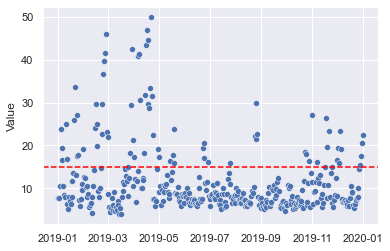

In [8]:
df['Date'] = df['DateTime'].dt.date

sns.scatterplot(x=df['Date'].unique(), y=df.groupby('Date').mean()['Value'])

plt.axhline(y=15, color='red', linestyle='--')
plt.show()

In [9]:
# number of date above WHO guideline
(df.groupby('Date').mean()['Value']>15).sum()

74

In [10]:
# annual mean for each site
df.groupby('Site').mean()['Value']

Site
BL0    10.908521
BX9    11.170749
CD1    11.058464
CD9    13.712563
CR8    10.125421
CT2    13.902287
CT3    12.142583
GB0    12.569166
GN3    13.363480
GN6    11.039737
GR4    10.887037
GR9    10.482015
HP1     9.931490
HV1    11.368690
KC1     9.567551
LH0     9.412646
LW2    15.422345
MY7    14.190663
ST5    11.732403
TD5    11.686217
TH4    12.610338
Name: Value, dtype: float64

In [11]:
exp_names = df.columns[5:11].tolist()
var_names = exp_names + ['Gsp_edge', 'Gsp_per_tRd_len']
cond_names = df.columns[12:15].tolist()

In [12]:
loc_gdf = loc_gdf.set_index('siteid')

In [13]:
loc_gdf = pd.merge(df.groupby('Site').mean()[var_names], loc_gdf, left_index=True, right_index=True)

In [14]:
# kernel weight matrix for the sites
weight = Kernel.from_dataframe(loc_gdf, geom_col='geometry', function='gaussian')

In [15]:
for var in var_names:
    moran_temp = Moran(loc_gdf[var].values, weight)
    print("Global Moran's I for " + var + ' is ', round(moran_temp.I, 5), 
          ' p-value: ', round(moran_temp.p_norm, 5))

Global Moran's I for pct_nUnC_Rd_Gsp is  0.06174  p-value:  0.05658
Global Moran's I for pct_nA_Rd_Gsp is  0.07157  p-value:  0.03805
Global Moran's I for pct_nB_Rd_Gsp is  0.11358  p-value:  0.00525
Global Moran's I for pct_nCUn_Rd_Gsp is  0.15885  p-value:  0.00037
Global Moran's I for pct_nMo_Rd_Gsp is  0.39593  p-value:  0.0
Global Moran's I for pct_nO_Rd_Gsp is  0.01649  p-value:  0.25657
Global Moran's I for Gsp_edge is  0.01709  p-value:  0.25236
Global Moran's I for Gsp_per_tRd_len is  0.14019  p-value:  0.00117


<AxesSubplot:>

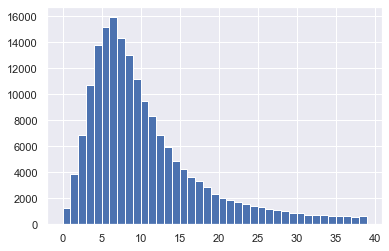

In [16]:
df['Value'].hist(bins=list(range(40)))

<AxesSubplot:>

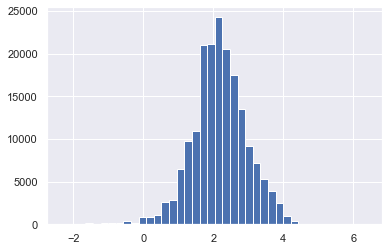

In [17]:
df['log_Value'] = np.log(df['Value'])
df['log_Value'].hist(bins=40)

array([[<AxesSubplot:title={'center':'pct_nUnC_Rd_Gsp'}>,
        <AxesSubplot:title={'center':'pct_nA_Rd_Gsp'}>,
        <AxesSubplot:title={'center':'pct_nB_Rd_Gsp'}>],
       [<AxesSubplot:title={'center':'pct_nCUn_Rd_Gsp'}>,
        <AxesSubplot:title={'center':'pct_nMo_Rd_Gsp'}>,
        <AxesSubplot:title={'center':'pct_nO_Rd_Gsp'}>],
       [<AxesSubplot:title={'center':'Gsp_edge'}>,
        <AxesSubplot:title={'center':'Gsp_per_tRd_len'}>,
        <AxesSubplot:title={'center':'bp_mean'}>],
       [<AxesSubplot:title={'center':'tmp_mean'}>,
        <AxesSubplot:title={'center':'Prec_mean'}>, <AxesSubplot:>]],
      dtype=object)

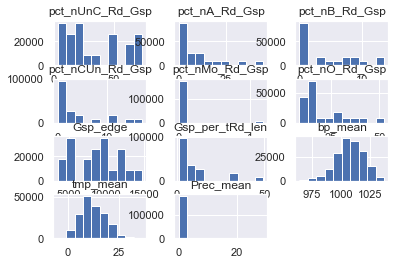

In [19]:
df[var_names + cond_names].hist(bins=10)

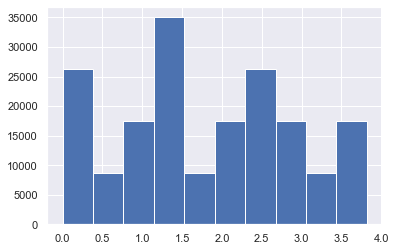

In [47]:
plt.hist(np.log(df['pct_nA_Rd_Gsp']+1))
plt.show()

In [27]:
df['log1_pct_nA_Rd_Gsp'] = np.log(df['pct_nA_Rd_Gsp']+1)
exp_names[1] = 'log1_pct_nA_Rd_Gsp'
var_names[1] = 'log1_pct_nA_Rd_Gsp'

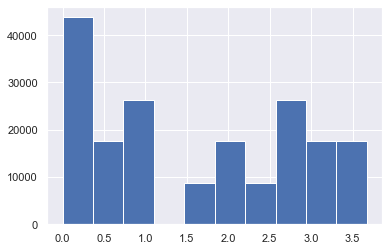

In [41]:
plt.hist(np.sqrt(df['pct_nB_Rd_Gsp']))
plt.show()

In [42]:
df['sqrt_pct_nB_Rd_Gsp'] = np.sqrt(df['pct_nB_Rd_Gsp'])
exp_names[2] = 'sqrt_pct_nB_Rd_Gsp'
var_names[2] = 'sqrt_pct_nB_Rd_Gsp'

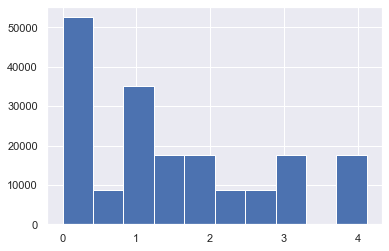

In [49]:
plt.hist(np.sqrt(df['pct_nCUn_Rd_Gsp']))
plt.show()

In [50]:
df['sqrt_pct_nCUn_Rd_Gsp'] = np.sqrt(df['pct_nCUn_Rd_Gsp'])
exp_names[3] = 'sqrt_pct_nCUn_Rd_Gsp'
var_names[3] = 'sqrt_pct_nCUn_Rd_Gsp'

In [79]:
(df['pct_nMo_Rd_Gsp']>0).sum()/8760

1.0

There is only one site that has nearby motorway, so we should exclude motorway from the dataset, otherwise the result will be biased.

In [80]:
df.drop('pct_nMo_Rd_Gsp', axis=1, inplace=True)
exp_names.remove('pct_nMo_Rd_Gsp')
var_names.remove('pct_nMo_Rd_Gsp')

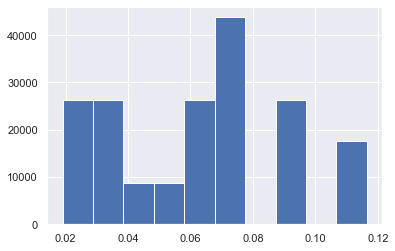

In [62]:
plt.hist(1/df['pct_nO_Rd_Gsp'])
plt.show()

In [63]:
df['rec_pct_nO_Rd_Gsp'] = 1/df['pct_nO_Rd_Gsp']
exp_names[4] = 'rec_pct_nO_Rd_Gsp'
var_names[4] = 'rec_pct_nO_Rd_Gsp'

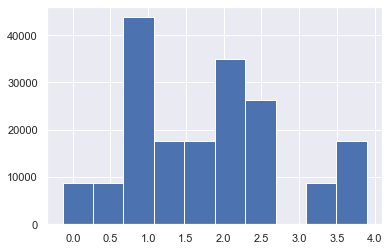

In [64]:
plt.hist(np.log(df['Gsp_per_tRd_len']))
plt.show()

In [65]:
df['log_Gsp_per_tRd_len'] = np.log(df['Gsp_per_tRd_len'])
var_names[6] = 'log_Gsp_per_tRd_len'

In [81]:
(df['Prec_mean']>0).sum()/21

629.0

There is 629 out of 8760 hours in 2019 recorded raining, which is only around 7% of the time. Hence it would be better to use a categorical data (0 being not raining and 1 being raining) to represent the weather.

In [83]:
df['Prec_mean'] = (df['Prec_mean']>0).astype(int)
df['Prec_mean'].sum()/21

629.0

<AxesSubplot:xlabel='hour'>

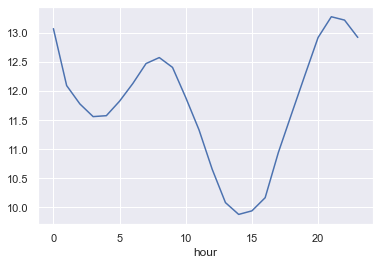

In [87]:
df['hour'] = df['DateTime'].dt.hour
df.groupby('hour').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofweek'>

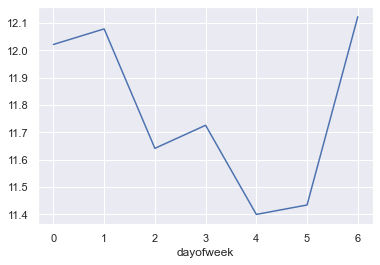

In [88]:
df['dayofweek'] = df['DateTime'].dt.dayofweek
df.groupby('dayofweek').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofmonth'>

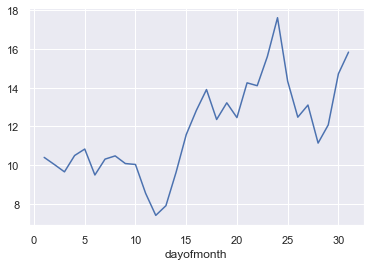

In [89]:
df['dayofmonth'] = df['DateTime'].dt.day
df.groupby('dayofmonth').mean()['Value'].plot()

In [90]:
def get_importance(reg, features, target, feature_names, rep=50, method='r2'):
    mean = []
    std = []
    importance = permutation_importance(reg, features, target, n_repeats=rep,
                                        random_state=25, scoring=method)
    for i in range(len(feature_names)):
        mean.append(round(importance.importances_mean[i], 5))
        std.append(round(importance.importances_std[i], 5))
    return mean, std

In [91]:
def get_cv_score(reg, features, target, iter=50, split=10, method='r2'):
    score = []
    for i in range(iter):
        kf = KFold(n_splits=split, shuffle=True, random_state=i)
        cv = cross_val_score(reg, features, target, cv=kf, scoring=method).tolist()
        score = score + cv
    
    return (np.mean(score), np.std(score))

In [92]:
scaler = MinMaxScaler()

In [93]:
reg = LinearRegression()
var = var_names + cond_names

ap_X = df[var].values
ap_y = df['log_Value'].values

ap_X_train, ap_X_test, ap_y_train, ap_y_test = train_test_split(ap_X, ap_y, shuffle=True, random_state=25)

ap_X_train = scaler.fit_transform(ap_X_train)
ap_X_test = scaler.fit_transform(ap_X_test)

reg.fit(ap_X_train, ap_y_train)

get_importance(reg, ap_X_test, ap_y_test, var)

([0.05592,
  0.00082,
  0.00016,
  0.0004,
  0.00537,
  0.00686,
  0.03881,
  0.11223,
  0.04755,
  0.00304],
 [0.00146,
  0.00024,
  5e-05,
  0.00014,
  0.00041,
  0.00051,
  0.00125,
  0.00251,
  0.00139,
  0.00035])

In [94]:
reg.score(ap_X_test, ap_y_test)

0.08938284075993341

In [ ]:
moran = []
for time in df['DateTime'].unique():
    moran_temp = Moran(df[df['DateTime']==time].log_Value.values, weight)
    moran.append([round(moran_temp.I, 5), round(moran_temp.p_norm, 5)])
moran_df = pd.DataFrame(df['DateTime'].unique(), columns=['DateTime'])
moran_df[['moran', 'p-value']] = moran
moran_df.head()

In [ ]:
moran_df['hour'] = moran_df['DateTime'].dt.hour

In [ ]:
fig,ax = plt.subplots(4, 6, figsize=(24,16))
i = 0
for hour in range(24):
    sns.lineplot(x=moran_df['DateTime'].dt.date.unique(), 
                 y=moran_df[moran_df['hour']==hour].moran.values, 
                 ax=ax[i//6, i%6], linewidth=1)
    i+=1
plt.show()

In [95]:
h_fi = []
h_score = []
h_coef = []
for hour in df['hour'].unique():
    X = df[df['hour']==hour].loc[:,var].values
    y = df[df['hour']==hour].loc[:,'log_Value'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=25)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    reg.fit(X_train, y_train)
    
    fi_mean, fi_std = get_importance(reg, X_test, y_test, feature_names=var)
    h_fi.append(fi_mean + fi_std)
    
    h_score.append(reg.score(X_test, y_test))
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    h_coef.append(coef)
    
h_fi = pd.DataFrame(h_fi, columns=['fi_' + elem for elem in var] + ['fi_std_' + elem for elem in var])
h_score = pd.DataFrame(h_score, columns=['r2'])
h_coef = pd.DataFrame(h_coef, columns=var+['intercept'])

In [96]:
h_reg = pd.concat([h_coef, h_score, h_fi], axis=1)
h_reg

,pct_nUnC_Rd_Gsp,log1_pct_nA_Rd_Gsp,sqrt_pct_nB_Rd_Gsp,sqrt_pct_nCUn_Rd_Gsp,rec_pct_nO_Rd_Gsp,Gsp_edge,log_Gsp_per_tRd_len,bp_mean,tmp_mean,Prec_mean,...,fi_std_pct_nUnC_Rd_Gsp,fi_std_log1_pct_nA_Rd_Gsp,fi_std_sqrt_pct_nB_Rd_Gsp,fi_std_sqrt_pct_nCUn_Rd_Gsp,fi_std_rec_pct_nO_Rd_Gsp,fi_std_Gsp_edge,fi_std_log_Gsp_per_tRd_len,fi_std_bp_mean,fi_std_tmp_mean,fi_std_Prec_mean
0,0.390867,0.058795,-0.030532,-0.037065,0.091255,-0.052323,0.121538,1.161008,-1.124698,-0.070658,...,0.00779,0.00108,0.00056,0.00065,0.00130,0.00064,0.00162,0.01032,0.01022,0.00107
1,0.513442,0.018024,-0.077873,-0.014020,-0.151986,-0.172916,0.603812,1.242337,-1.018494,-0.133442,...,0.00916,0.00030,0.00141,0.00023,0.00194,0.00210,0.00788,0.00993,0.00821,0.00151
2,0.565365,0.039954,-0.098172,-0.030112,-0.164939,-0.222290,0.679714,1.253137,-0.973749,-0.212244,...,0.01039,0.00063,0.00160,0.00043,0.00203,0.00270,0.00938,0.00953,0.00784,0.00308
3,0.506809,0.024122,-0.074286,0.021714,-0.143366,-0.141178,0.551021,1.335479,-0.915499,-0.191201,...,0.00891,0.00037,0.00127,0.00032,0.00179,0.00171,0.00698,0.01159,0.00799,0.00225
4,0.480421,0.047005,-0.085581,0.023800,-0.174932,-0.155843,0.559065,1.355100,-0.902167,-0.017977,...,0.00919,0.00070,0.00136,0.00035,0.00201,0.00209,0.00809,0.01048,0.00745,0.00027
5,0.364414,0.071382,0.002192,0.085080,-0.178374,-0.183381,0.496932,1.213737,-0.796164,-0.284973,...,0.00722,0.00107,0.00004,0.00134,0.00224,0.00188,0.00648,0.00951,0.00723,0.00321
6,0.276142,0.129989,0.027622,0.081123,-0.139555,-0.165084,0.402747,1.205649,-0.682597,-0.322841,...,0.00569,0.00211,0.00040,0.00119,0.00162,0.00184,0.00572,0.00921,0.00622,0.00401
7,0.242166,0.105256,0.039909,0.066040,-0.089074,-0.095478,0.243124,1.079892,-0.596154,-0.561401,...,0.00485,0.00178,0.00066,0.00111,0.00123,0.00126,0.00347,0.01000,0.00641,0.00731
8,0.292975,0.137320,0.032256,0.007263,-0.106643,-0.167827,0.283154,1.099142,-0.530264,-0.268815,...,0.00595,0.00210,0.00054,0.00013,0.00156,0.00235,0.00411,0.00959,0.00542,0.00417
9,0.354532,0.181676,0.012588,-0.036369,-0.118700,-0.240401,0.351079,1.076193,-0.549673,0.049317,...,0.00658,0.00288,0.00017,0.00068,0.00179,0.00348,0.00508,0.01004,0.00527,0.00058


<AxesSubplot:>

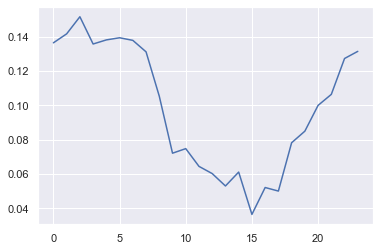

In [97]:
h_reg['r2'].plot()

No handles with labels found to put in legend.


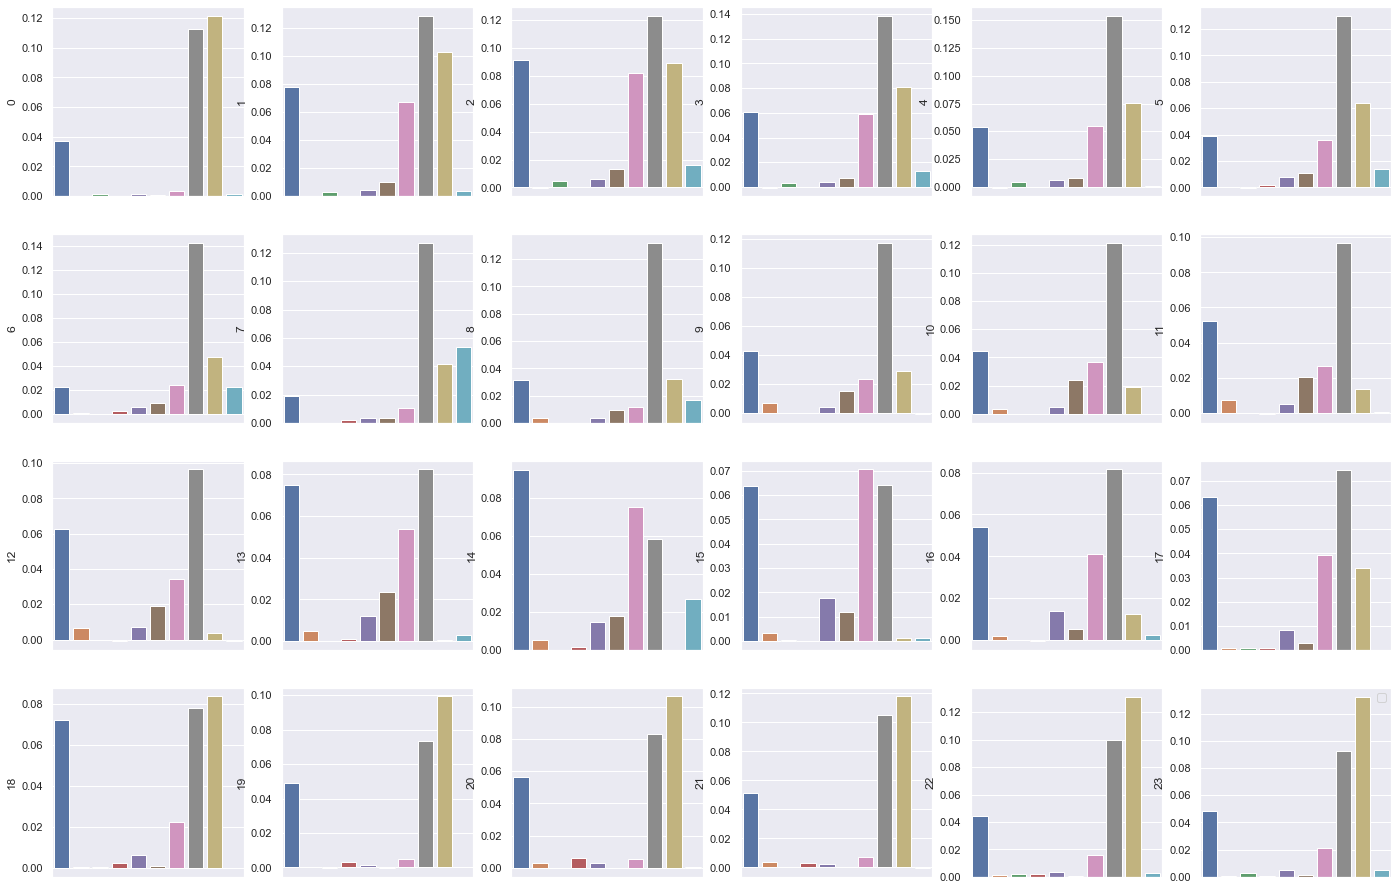

In [98]:
fig, ax = plt.subplots(4, 6, figsize=(24, 16))
i = 0
for hour in range(24):
    g = sns.barplot(x=['fi_' + elem for elem in var], y=h_reg.loc[hour, ['fi_' + elem for elem in var]],
                    ax=ax[i//6, i%6])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [99]:
# set up a new column for month information
df['month'] = df['DateTime'].dt.month

In [ ]:
moran_df['month'] = moran_df['DateTime'].dt.month

In [ ]:
fig,ax = plt.subplots(3, 4, figsize=(16,12))
i = 0
for month in range(1,13):
    sns.lineplot(x='DateTime', y='moran', data=moran_df[moran_df['month']==month],
                 ax=ax[i//4, i%4], linewidth=1)
    i+=1
plt.show()

In [100]:
m_fi = []
m_score = []
m_coef = []
for month in df['month'].unique():
    X = df[df['month']==month].loc[:, var].values
    y = df[df['month']==month].loc[:, 'log_Value'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=25)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    reg.fit(X_train, y_train)
    
    fi_mean, fi_std = get_importance(reg, X_test, y_test, feature_names=var)
    m_fi.append(fi_mean + fi_std)

    m_score.append(reg.score(X_test, y_test))
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    m_coef.append(coef)
    
m_fi = pd.DataFrame(m_fi, columns=['fi_' + elem for elem in var] + ['fi_std_' + elem for elem in var])
m_score = pd.DataFrame(m_score, columns=['r2'])
m_coef = pd.DataFrame(m_coef, columns=var+['intercept'])

In [101]:
m_reg = pd.concat([m_coef, m_score, m_fi], axis=1)
m_reg

,pct_nUnC_Rd_Gsp,log1_pct_nA_Rd_Gsp,sqrt_pct_nB_Rd_Gsp,sqrt_pct_nCUn_Rd_Gsp,rec_pct_nO_Rd_Gsp,Gsp_edge,log_Gsp_per_tRd_len,bp_mean,tmp_mean,Prec_mean,...,fi_std_pct_nUnC_Rd_Gsp,fi_std_log1_pct_nA_Rd_Gsp,fi_std_sqrt_pct_nB_Rd_Gsp,fi_std_sqrt_pct_nCUn_Rd_Gsp,fi_std_rec_pct_nO_Rd_Gsp,fi_std_Gsp_edge,fi_std_log_Gsp_per_tRd_len,fi_std_bp_mean,fi_std_tmp_mean,fi_std_Prec_mean
0,0.344648,0.008895,-0.013290,-0.086133,-0.202004,-0.164744,0.466060,0.764704,-1.986158,0.012025,...,0.00451,0.00010,0.00017,0.00111,0.00230,0.00169,0.00458,0.00856,0.01615,0.00008
1,0.228521,-0.013597,-0.078164,-0.160702,-0.254604,-0.185060,0.166009,2.166013,-0.416182,0.157717,...,0.00242,0.00013,0.00103,0.00181,0.00251,0.00163,0.00125,0.01750,0.00235,0.00139
2,0.495577,-0.051957,-0.114571,-0.197988,-0.331987,-0.215521,0.598097,1.477180,0.491122,-0.243848,...,0.00495,0.00057,0.00150,0.00257,0.00275,0.00169,0.00444,0.01266,0.00253,0.00244
3,0.190909,0.140029,-0.054867,-0.063708,-0.294227,-0.159863,0.527687,0.480714,0.831840,-0.023524,...,0.00211,0.00148,0.00067,0.00078,0.00264,0.00169,0.00499,0.00574,0.00708,0.00015
4,0.270458,0.090762,-0.033214,-0.093643,-0.095218,-0.097919,0.318379,-0.479175,-0.400085,-0.298580,...,0.00470,0.00139,0.00063,0.00163,0.00151,0.00136,0.00443,0.00452,0.00467,0.00391
5,0.429554,0.139683,0.106980,-0.118256,0.001177,-0.200975,0.609279,0.135320,0.883585,0.178114,...,0.00773,0.00218,0.00188,0.00198,0.00002,0.00241,0.00869,0.00140,0.00753,0.00266
6,0.649788,0.120874,-0.010875,-0.000170,-0.210940,-0.293840,0.791925,-0.037103,0.936168,-0.058817,...,0.01223,0.00178,0.00015,0.00000,0.00318,0.00436,0.01028,0.00050,0.00851,0.00103
7,0.594946,0.067450,0.079658,0.015054,-0.164798,-0.152950,0.634154,0.673370,0.561768,0.028643,...,0.00905,0.00092,0.00117,0.00020,0.00212,0.00190,0.00706,0.00790,0.00510,0.00033
8,0.383420,0.212500,-0.062840,0.133441,-0.106951,-0.202530,0.371937,0.436469,-0.204028,-0.032646,...,0.00747,0.00313,0.00119,0.00239,0.00107,0.00260,0.00474,0.00550,0.00191,0.00015
9,0.352558,0.124175,-0.114273,0.019996,-0.173097,-0.082446,0.166022,0.373366,-0.686350,0.086419,...,0.00497,0.00147,0.00162,0.00029,0.00211,0.00092,0.00176,0.00425,0.00540,0.00046


<AxesSubplot:>

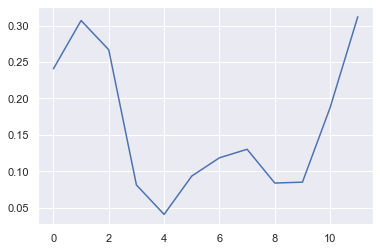

In [102]:
m_reg['r2'].plot()

No handles with labels found to put in legend.


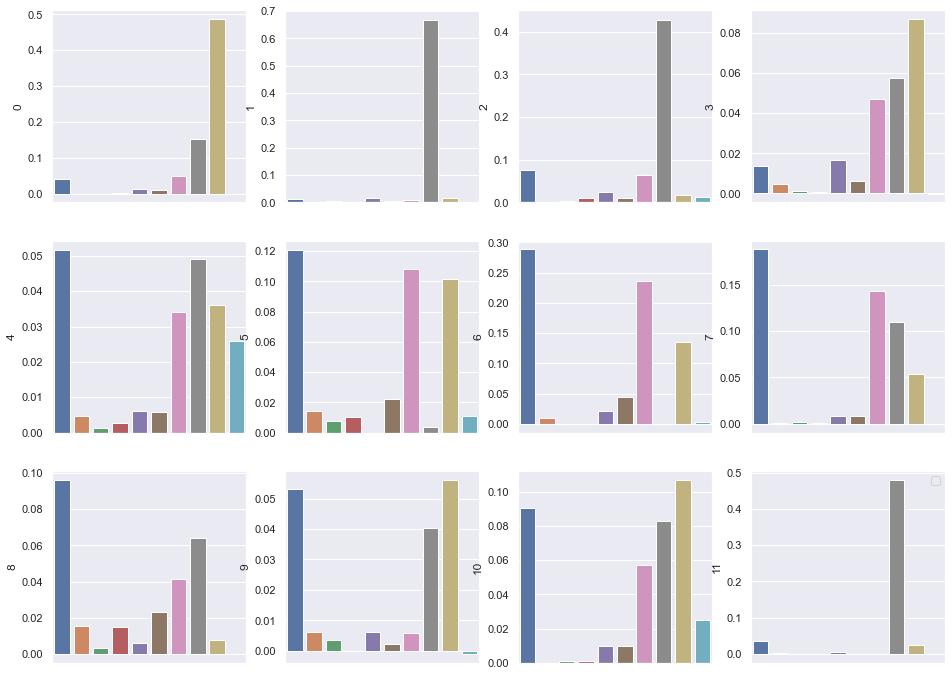

In [103]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
i = 0
for month in range(1,13):
    g = sns.barplot(x=['fi_' + elem for elem in var], y=m_reg.loc[month-1, ['fi_' + elem for elem in var]],
                    ax=ax[i//4, i%4])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

<AxesSubplot:xlabel='month'>

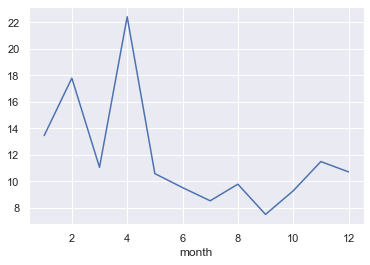

In [104]:
df.groupby('month').mean()['Value'].plot()

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Site                  183960 non-null  object        
 1   DateTime              183960 non-null  datetime64[ns]
 2   Value                 183960 non-null  float64       
 3   Gsp_area              183960 non-null  float64       
 4   Gsp_edge              183960 non-null  float64       
 5   pct_nUnC_Rd_Gsp       183960 non-null  float64       
 6   pct_nA_Rd_Gsp         183960 non-null  float64       
 7   pct_nB_Rd_Gsp         183960 non-null  float64       
 8   pct_nCUn_Rd_Gsp       183960 non-null  float64       
 9   pct_nO_Rd_Gsp         183960 non-null  float64       
 10  Gsp_per_tRd_len       183960 non-null  float64       
 11  bp_mean               183960 non-null  float64       
 12  tmp_mean              183960 non-null  float64       
 13 

In [106]:
high_period = df[df['month'].isin([1, 2, 4])].drop(['hour','dayofweek','dayofmonth','month'],axis=1)
low_period = df[~df['month'].isin([1, 2, 4])].drop(['hour','dayofweek','dayofmonth','month'],axis=1)

print('high period: '+str(high_period.shape)+'\nlow period: '+str(low_period.shape))

high period: (44856, 21)
low period: (139104, 21)


In [107]:
hp_X = high_period[var].values
hp_y = high_period['log_Value'].values

hp_X_train, hp_X_test, hp_y_train, hp_y_test = train_test_split(hp_X, hp_y, shuffle=True, random_state=25)

hp_X_train = scaler.fit_transform(hp_X_train)
hp_X_test = scaler.fit_transform(hp_X_test)

reg.fit(hp_X_train, hp_y_train)

get_importance(reg, hp_X_test, hp_y_test, feature_names=var)

([0.02019,
  0.00078,
  0.00013,
  0.0026,
  0.01129,
  0.00723,
  0.02198,
  0.0858,
  0.00846,
  0.00348],
 [0.00184,
  0.00028,
  0.00031,
  0.00059,
  0.00168,
  0.00106,
  0.00232,
  0.00367,
  0.00127,
  0.00066])

In [108]:
reg.score(hp_X_test, hp_y_test)

0.05847324733847947

In [109]:
reg.coef_.tolist() + [reg.intercept_]

[0.240370787842208,
 0.04250936615349338,
 -0.04057073011587831,
 -0.0737909218162022,
 -0.24897356202011067,
 -0.1544247971293441,
 0.38302608292794715,
 0.7788529349157306,
 0.3647194604880836,
 -0.12314031420870794,
 1.8987073254857567]

In [110]:
lp_X = low_period[var].values
lp_y = low_period['log_Value'].values

lp_X_train, lp_X_test, lp_y_train, lp_y_test = train_test_split(lp_X, lp_y, shuffle=True, random_state=25)
lp_X_train = scaler.fit_transform(lp_X_train)
lp_X_test = scaler.fit_transform(lp_X_test)
reg.fit(lp_X_train, lp_y_train)

get_importance(reg, lp_X_test, lp_y_test, feature_names=var)

([0.08497,
  0.00154,
  7e-05,
  0.00025,
  0.00322,
  0.00648,
  0.04212,
  0.09712,
  0.01814,
  0.00262],
 [0.00174,
  0.00024,
  7e-05,
  0.00011,
  0.00039,
  0.00057,
  0.0013,
  0.0018,
  0.00092,
  0.00038])

In [111]:
reg.score(lp_X_test, lp_y_test)

0.07570901997434187

In [112]:
reg.coef_.tolist() + [reg.intercept_]

[0.4287157802704214,
 0.06371296033021148,
 -0.014332938082346161,
 -0.02977873494081836,
 -0.11280459169772182,
 -0.1443474653084993,
 0.3933703207285165,
 0.9524699905857369,
 -0.4301110516480282,
 -0.10553164171963922,
 1.3665510366735842]

# Mean analysis

In [113]:
hmean_df = df.groupby(['hour', 'Site']).mean()
hmean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 504 entries, (0, 'BL0') to (23, 'TH4')
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Value                 504 non-null    float64
 1   Gsp_area              504 non-null    float64
 2   Gsp_edge              504 non-null    float64
 3   pct_nUnC_Rd_Gsp       504 non-null    float64
 4   pct_nA_Rd_Gsp         504 non-null    float64
 5   pct_nB_Rd_Gsp         504 non-null    float64
 6   pct_nCUn_Rd_Gsp       504 non-null    float64
 7   pct_nO_Rd_Gsp         504 non-null    float64
 8   Gsp_per_tRd_len       504 non-null    float64
 9   bp_mean               504 non-null    float64
 10  tmp_mean              504 non-null    float64
 11  Prec_mean             504 non-null    float64
 12  log_Value             504 non-null    float64
 13  log1_pct_nA_Rd_Gsp    504 non-null    float64
 14  sqrt_pct_nB_Rd_Gsp    504 non-null    float64
 15  sqrt_p

In [114]:
hmean_df.drop(['bp_mean', 'tmp_mean', 'Prec_mean', 'dayofweek', 'dayofmonth', 'month'], axis=1, inplace=True)

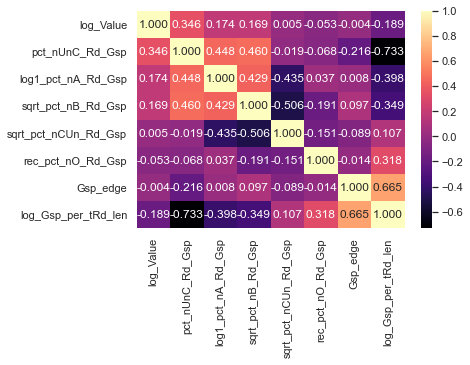

In [115]:
sns.heatmap(hmean_df[['log_Value']+var_names].corr().round(4),annot=True,fmt='.3f',cmap='magma')
plt.show()

In [127]:
def get_corr(df,iter_range,method='pearson',features=var_names,target='log_Value'):
    result=[]
    for index in iter_range:
        result.append(df.loc[(index,)].corr(method=method).loc[features,target])
    result=np.asarray(result)
    return result

In [117]:
def get_moran(df,iter_range,w=weight,target='log_Value'):
    result=[]
    for index in iter_range:
        result.append(Moran(df.loc[(index,),target].values,w).I)
    return result

In [147]:
def get_cv(df, reg, features, target, iter=100, splits=3):
    cv_r2 = []
    cv_tau = []

    for i in range(iter):
        kf = KFold(n_splits=splits, shuffle=True, random_state=i)
        cvprd = cross_val_predict(reg, features, target, cv=kf)
        
        r = stats.pearsonr(target,cvprd)[0]
        t, p_value = stats.kendalltau(target, cvprd)
        
        cv_r2.append(r**2)
        cv_tau.append(t)

    return [round(np.mean(cv_r2),5), round(np.std(cv_r2),5), round(np.mean(cv_tau),5), round(np.std(cv_tau),5)]

In [148]:
def get_reg_info(df, iter_range, features=var_names, target='log_Value', cv_split=3, reg=LinearRegression()):
    result = []
    for index in iter_range:
        X = df.loc[(index,), features].values        
        y = df.loc[(index,), target].values
        #X = scaler.fit_transform(X)
        
        reg.fit(X, y)
        coef = reg.coef_.tolist()
        cv = get_cv(df, reg, X, y, splits=cv_split)
        coef = coef + cv
        importance, std = get_importance(reg, X, y, features)
        coef = coef + importance + std
        result.append(coef)
    result = pd.DataFrame(result, columns=features+['cv_r2','r2_std','cv_tau','tau_std']+
                          ['fi_'+var for var in features]+['std_fi_'+var for var in features])
    return result

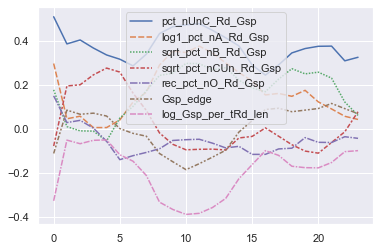

In [129]:
hmean_corr=get_corr(hmean_df,range(24))
sns.lineplot(data=hmean_corr,legend=False)
plt.legend(labels=var_names)
plt.show()

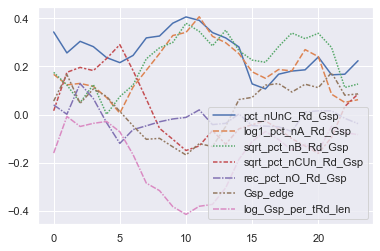

In [130]:
hmean_corr_sp=get_corr(hmean_df,range(24),method='spearman')
sns.lineplot(data=hmean_corr_sp,legend=False)
plt.legend(labels=var_names)
plt.show()

<AxesSubplot:>

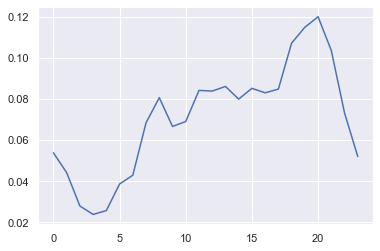

In [121]:
hmean_moran=get_moran(hmean_df,range(24))
sns.lineplot(x=range(24),y=hmean_moran)

<AxesSubplot:>

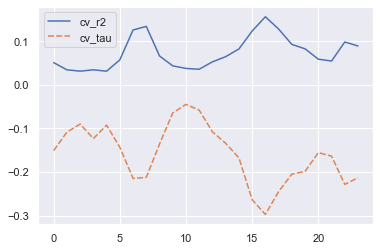

In [153]:
hmean_reg=get_reg_info(hmean_df,range(24), cv_split=4)
sns.lineplot(data=hmean_reg[['cv_r2','cv_tau']])

No handles with labels found to put in legend.


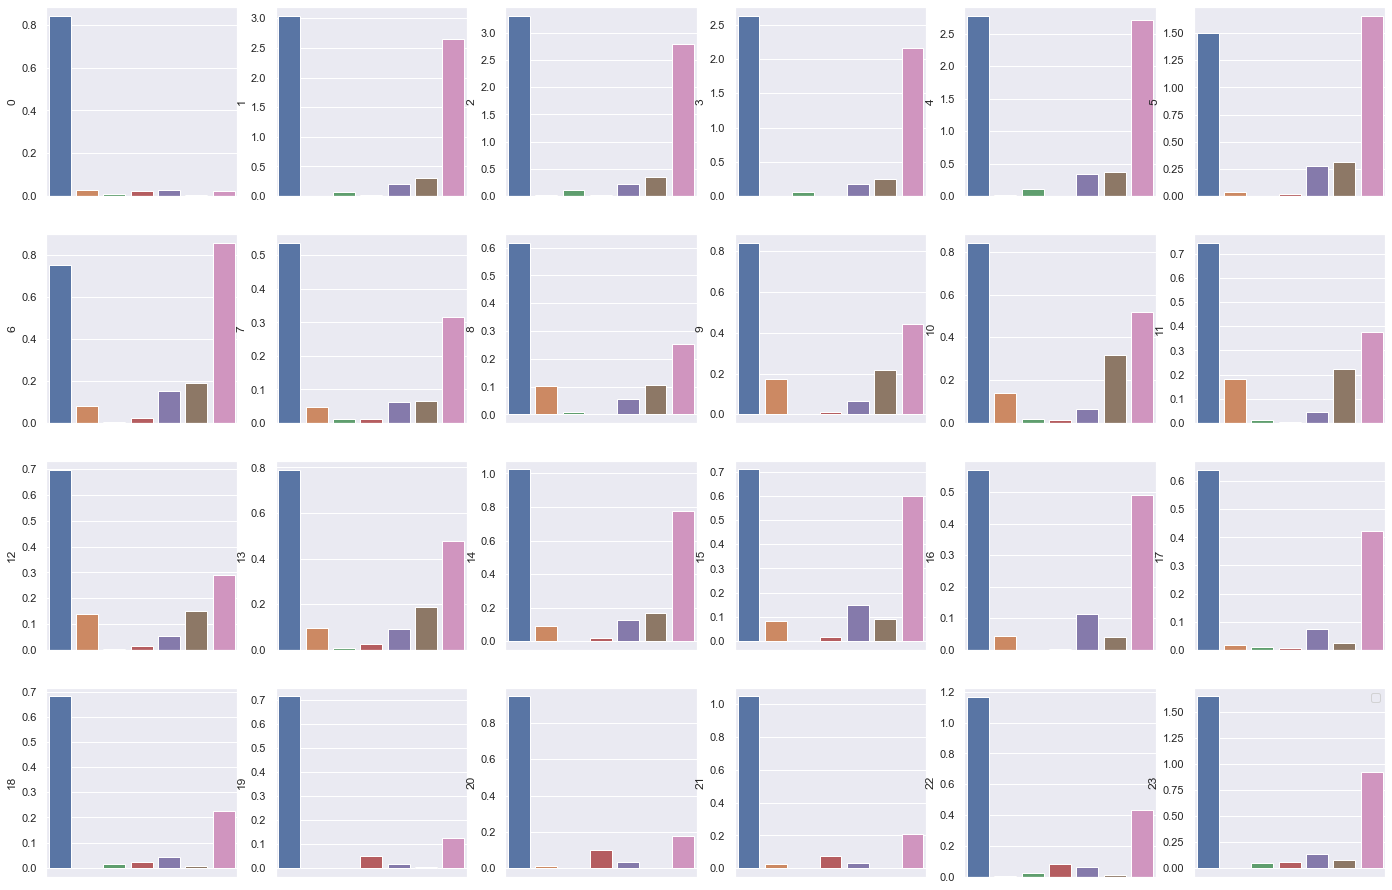

In [151]:
fig, ax = plt.subplots(4, 6, figsize=(24, 16))
i = 0
for hour in range(24):
    g = sns.barplot(x=['fi_' + elem for elem in var_names], 
                    y=hmean_reg.loc[hour, ['fi_' + elem for elem in var_names]],
                    ax=ax[i//6, i%6])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [125]:
mmean_df=df.groupby(['month','Site']).mean()
mmean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 252 entries, (1, 'BL0') to (12, 'TH4')
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Value                 252 non-null    float64
 1   Gsp_area              252 non-null    float64
 2   Gsp_edge              252 non-null    float64
 3   pct_nUnC_Rd_Gsp       252 non-null    float64
 4   pct_nA_Rd_Gsp         252 non-null    float64
 5   pct_nB_Rd_Gsp         252 non-null    float64
 6   pct_nCUn_Rd_Gsp       252 non-null    float64
 7   pct_nO_Rd_Gsp         252 non-null    float64
 8   Gsp_per_tRd_len       252 non-null    float64
 9   bp_mean               252 non-null    float64
 10  tmp_mean              252 non-null    float64
 11  Prec_mean             252 non-null    float64
 12  log_Value             252 non-null    float64
 13  log1_pct_nA_Rd_Gsp    252 non-null    float64
 14  sqrt_pct_nB_Rd_Gsp    252 non-null    float64
 15  sqrt_p

In [126]:
mmean_df.drop(['bp_mean','tmp_mean','Prec_mean','hour','dayofweek','dayofmonth'], axis=1, inplace=True)

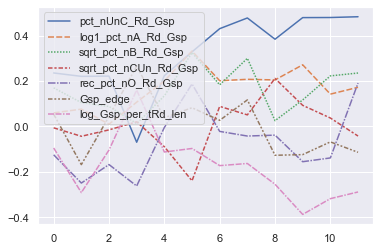

In [133]:
mmean_corr=get_corr(mmean_df,range(1,13))
sns.lineplot(data=mmean_corr,legend=False)
plt.legend(labels=var_names,loc='upper left')
plt.show()

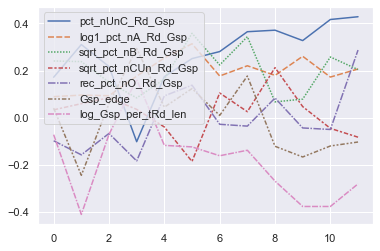

In [134]:
mmean_corr_sp=get_corr(mmean_df,range(1,13),method='spearman')
sns.lineplot(data=mmean_corr_sp,legend=False)
plt.legend(labels=var_names,loc='upper left')
plt.show()

<AxesSubplot:>

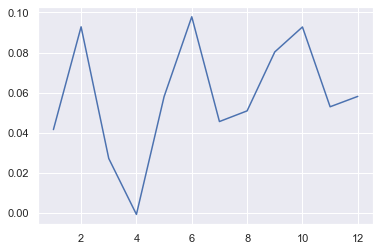

In [135]:
mmean_moran=get_moran(mmean_df,range(1,13))
sns.lineplot(x=range(1,13),y=mmean_moran)

<AxesSubplot:>

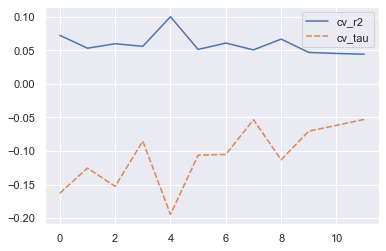

In [155]:
mmean_reg = get_reg_info(mmean_df,range(1,13),cv_split=2)
sns.lineplot(data=mmean_reg[['cv_r2','cv_tau']])

No handles with labels found to put in legend.


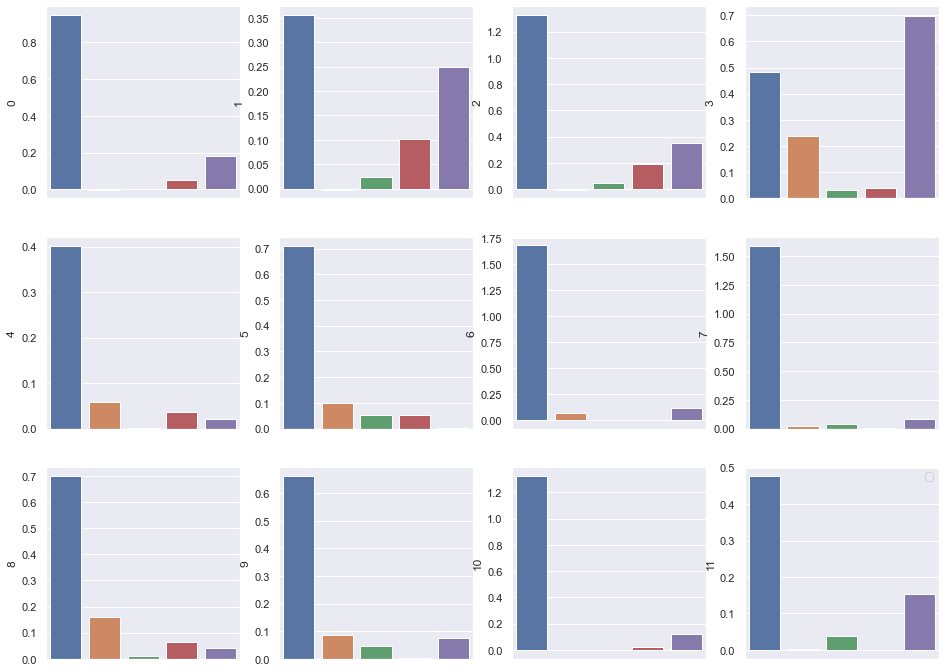

In [137]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
i = 0
for month in range(1,13):
    g = sns.barplot(x=['fi_' + elem for elem in exp_names], 
                    y=mmean_reg.loc[month-1, ['fi_' + elem for elem in exp_names]],
                    ax=ax[i//4, i%4])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [138]:
# identify high period and low period
high = df[df['month'].isin([1,2,4])].groupby('Site').mean()
low = df[~df['month'].isin([1,2,4])].groupby('Site').mean()

print('high: '+str(high.shape)+'\nlow: '+str(low.shape))

high: (21, 22)
low: (21, 22)


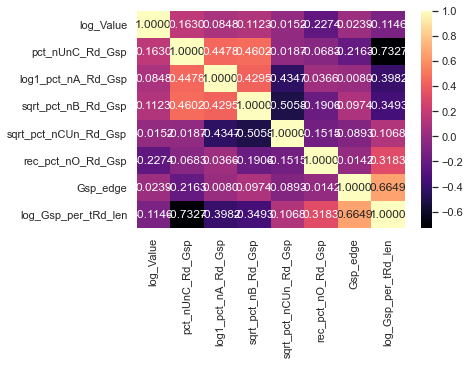

In [140]:
sns.heatmap(high[['log_Value']+var_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [141]:
high_moran=Moran(high['log_Value'].values,weight)
round(high_moran.I,5)

0.05232

In [142]:
reg_high=LinearRegression()
y_high = high['log_Value'].values
x_high = high[var_names].values

x_high = scaler.fit_transform(x_high)
reg_high.fit(x_high, y_high)
reg_high.score(x_high,y_high)

0.10857732537834996

In [143]:
prd_high = reg_high.predict(x_high)

r = stats.pearsonr(y_high, prd_high)[0]
r2 = r**2
t, p_value = stats.kendalltau(y_high, prd_high)
print('r2 (obs): ', round(r2, 5))
print('tau (obs): ', round(t, 5))

r2 (obs):  0.10858
tau (obs):  0.20952


In [ ]:
sns.heatmap(low[['Value']+exp_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
low_moran=Moran(low['Value'].values,weight)
round(low_moran.I,5)

In [ ]:
reg_low = LinearRegression()
y_low = low['Value'].values
x_low = low[exp_names].values
reg_low.fit(x_low, y_low)
prd_low = reg_low.predict(x_low)

r = low['Value'].corr(pd.Series(prd_low))
r2 = r**2
t = low['Value'].corr(pd.Series(prd_low), method='kendall')
print("r2 (cv): ", round(r2,3))   
print("tau (cv): ", round(t,3))

In [ ]:
sns.heatmap(all[['Value']+exp_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
all=df.groupby('Site').mean()
all_moran=Moran(all['Value'].values,weight)
round(all_moran.I,5)

In [ ]:
y_all=(all.groupby('Site').mean()['Value'].values)
x_all=(all.groupby('Site').mean()[exp_names].values)

reg.fit(x_all,y_all)
reg.score(x_all,y_all)